In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

### 1. Understand the Structure of the Dataset

In [2]:
# Load the data
df = pd.read_csv('bank-full.csv', delimiter=';')

In [3]:
# Preview the data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Data Types
print(df.dtypes)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


In [5]:
# Shape
df.shape

(45211, 17)

### 2. Check for Missing Values

In [6]:
# Missing value count
print(df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


### 3. Data Summary

#### Identifying categorical and numerical features

In [7]:
# Categorical Features
categorical_features = df.select_dtypes(include='object').columns[:-1] # exclude target variable
categorical_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [8]:
# Numerical Features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
numerical_features

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [9]:
# Identify discrete numerical features
discrete_features = [col for col in numerical_features if df[col].nunique() <= 25]
print('Discrete -', discrete_features)

# Identify continuous numerical features
continuous_features = [col for col in numerical_features if df[col].nunique() > 25]
print('Continuous - ', continuous_features)

Discrete - []
Continuous -  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [10]:
df.day.nunique()

31

In [11]:
np.array(sorted(df.day.unique()))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

Since `day` has 31 unique values which represents the 31 days of a month, It can be taken as a discrete feature.

In [12]:
# Identify discrete numerical features
discrete_features = [col for col in numerical_features if df[col].nunique() <= 31]
print('Discrete -', discrete_features)

# Identify continuous numerical features
continuous_features = [col for col in numerical_features if df[col].nunique() > 31]
print('Continuous - ', continuous_features)

Discrete - ['day']
Continuous -  ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [13]:
for col in categorical_features:
    print(col)
    print(df[col].value_counts())
    print()

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

marital
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

default
no     44396
yes      815
Name: default, dtype: int64

housing
yes    25130
no     20081
Name: housing, dtype: int64

loan
no     37967
yes     7244
Name: loan, dtype: int64

contact
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

poutcome
unknown    36959
failure

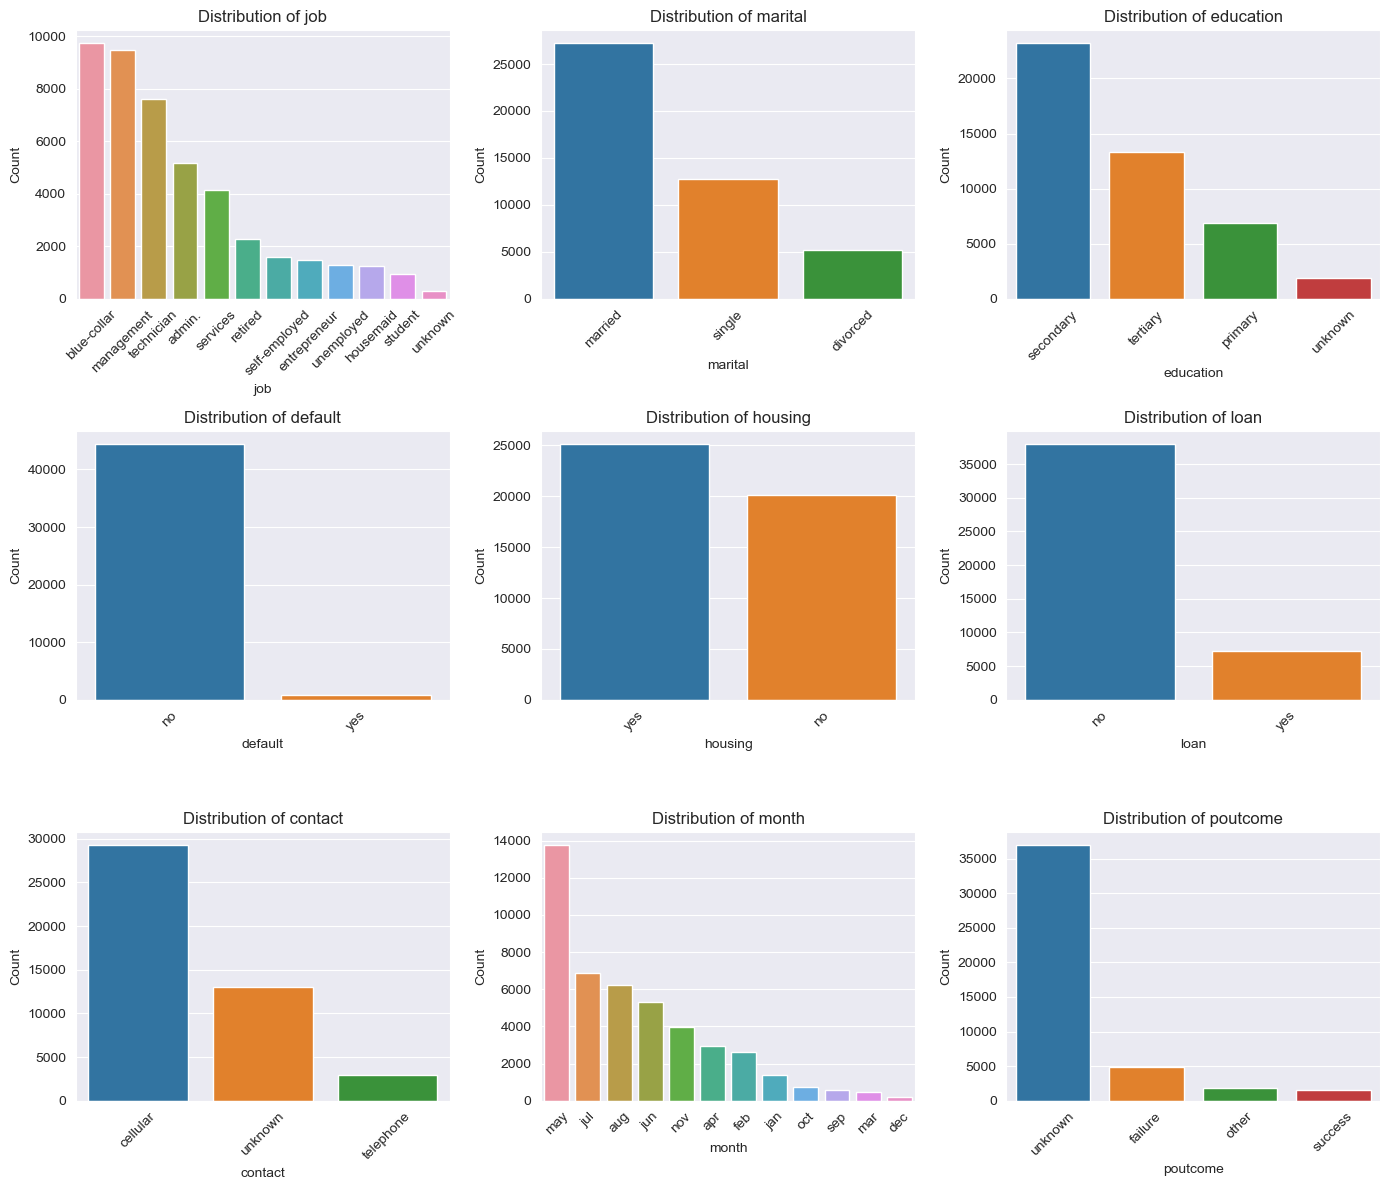

In [14]:
# Frequency Distribution - Categorical Features

# Create subplots: one row, multiple columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 12))  # Adjust grid size based on 8 subplots
axes = axes.flatten()  # Flatten the axes array to iterate easily

# Plot each column in a subplot
for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.show()

**Key Insights from Categorical Features**

1. **Job**: Most people have "blue-collar" or "management" jobs, with a small number in "unknown" categories.

2. **Marital Status**: Most individuals are "married," with fewer "single" or "divorced."

3. **Education**: Most people have "secondary" education, followed by "tertiary" and fewer with "primary" education. Some data is "unknown."

4. **Default**: Most people have no credit defaults, suggesting they are financially stable. Due to the high imbalance of data in this feature, this can be dropped

5. **Housing**: Most individuals have a housing loan ("yes").

6. **Loan**: Similar to housing, most people don’t have a loan. This may indicate that most individuals in the dataset are not in debt.

7. **Contact**: Most communication is via "cellular" phones, with some "unknown" data. This information could be less affective to the target variable from the meaning.

8. **Month**: "May," "July," and "August" have the most data, while "March," "December," and "September" have fewer.

9. **Poutcome**: Most outcomes are "unknown," with a few labeled as "failure," "other," or "success." This suggests that previous campaigns had mixed results, with many individuals not responding or receiving an unclear outcome. Since most values here are unknown and could give the wrong insights to the model, this feature can also be dropped.


In [16]:
# Descriptive Statistics - summary of numerical data
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**Key Insights from Continuous Numerical features**

1. **Age**: Ranges from 18 to 95, with an average of 41 years.
2. **Balance**: Wide range from -8019 to 102,127; average is 1362, with many low balances.
3. **Day**: Values between 1 and 31, with an average of 15.8.
4. **Duration**: Ranges from 0 to 4918 seconds, average of 258 seconds.
5. **Campaign**: Ranges from 1 to 63 contacts, average of 2.76.
6. **Pdays**: Most values are -1 (no previous contact), ranging up to 871.
7. **Previous**: Most people have 0 previous contacts, with an average of 0.58.

**Conclusion:**
- `balance` has some extreme outliers (negative and positive).
- Most people were contacted only once or twice, with many having no prior contact.

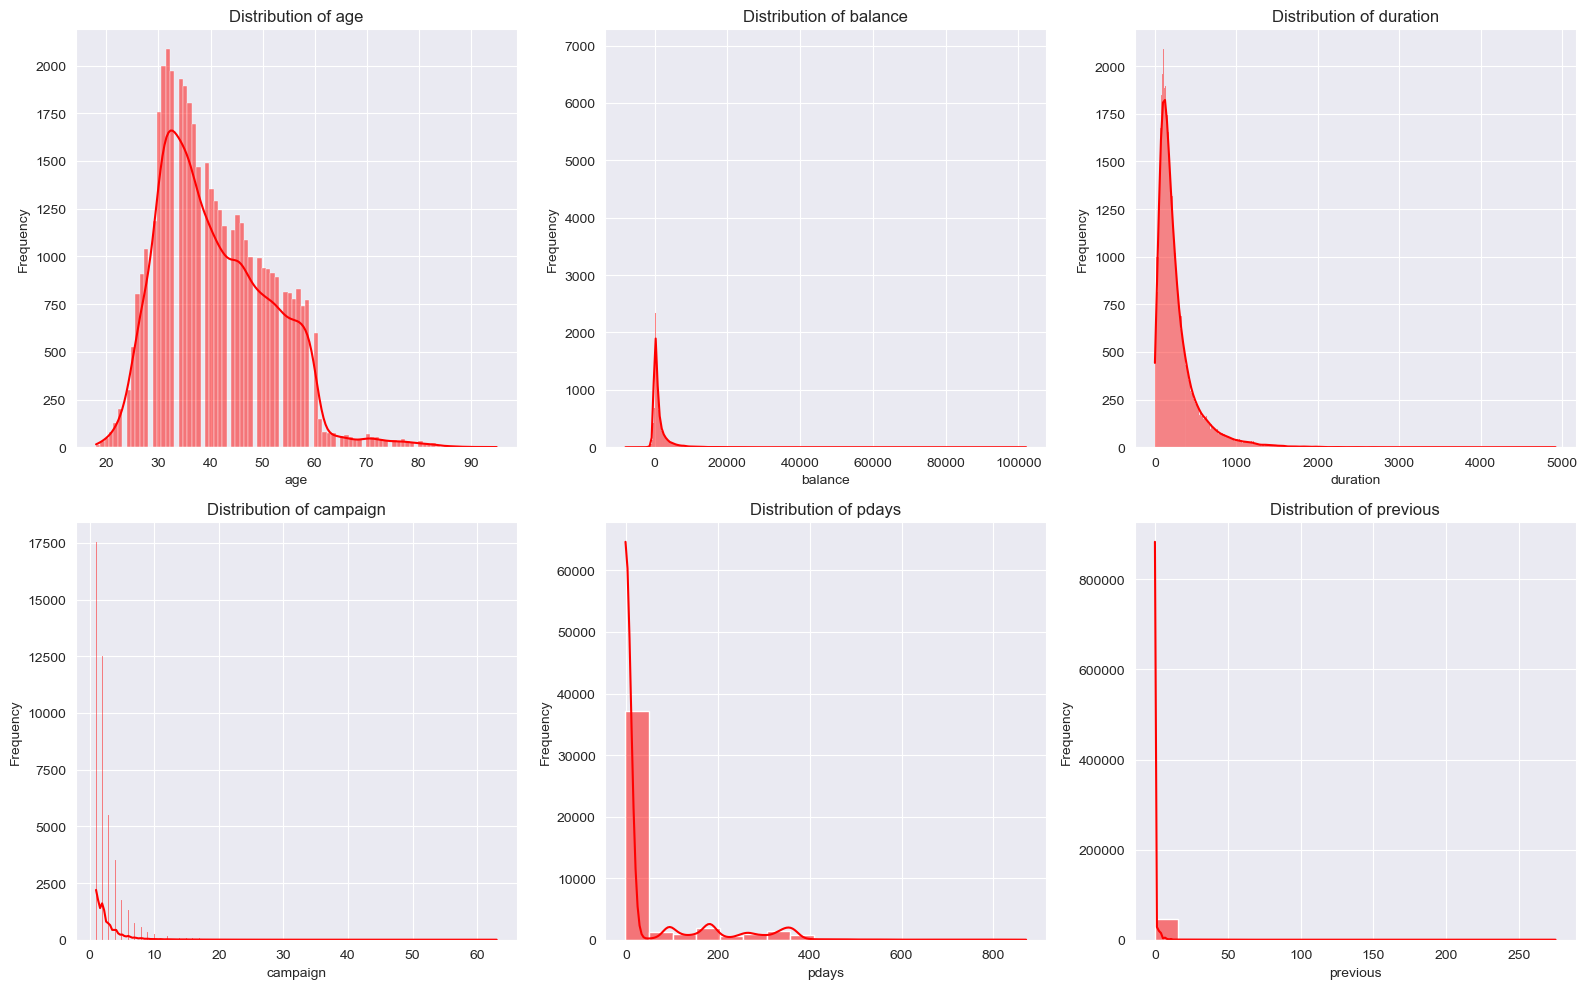

In [17]:
# Frequency Distributions

# Create subplots: 3 rows and 3 columns for 7 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))  # Adjust grid size
axes = axes.flatten()  # Flatten the axes array to iterate easily

# Plot each continuous column in a subplot
for i, col in enumerate(continuous_features):
    sns.histplot(data=df, x=col, color='red', kde=True, ax=axes[i])  # Use histogram with KDE
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Turn off unused axes (if any)
for j in range(len(continuous_features), len(axes)):
    axes[j].axis('off')

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.show()

While `age` is distributed normally with a small skewness to the right, all the other features are very much right skewed.

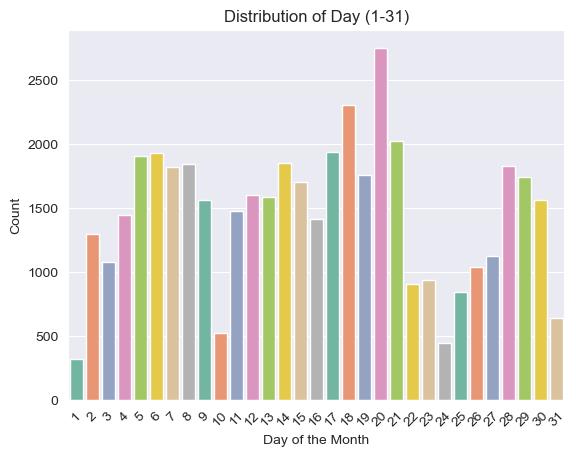

In [18]:
# Discrete Numerical feature - day

# Plotting the 'day' feature as a bar plot
plt.figure()
sns.countplot(x='day', data=df, palette='Set2')
plt.title('Distribution of Day (1-31)')
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Skewness: Certain days (e.g., middle of the month) have higher counts than others, this could suggest that more interactions occur on those days, possibly due to specific business or user behavior patterns.


### 4. Identify Outliers

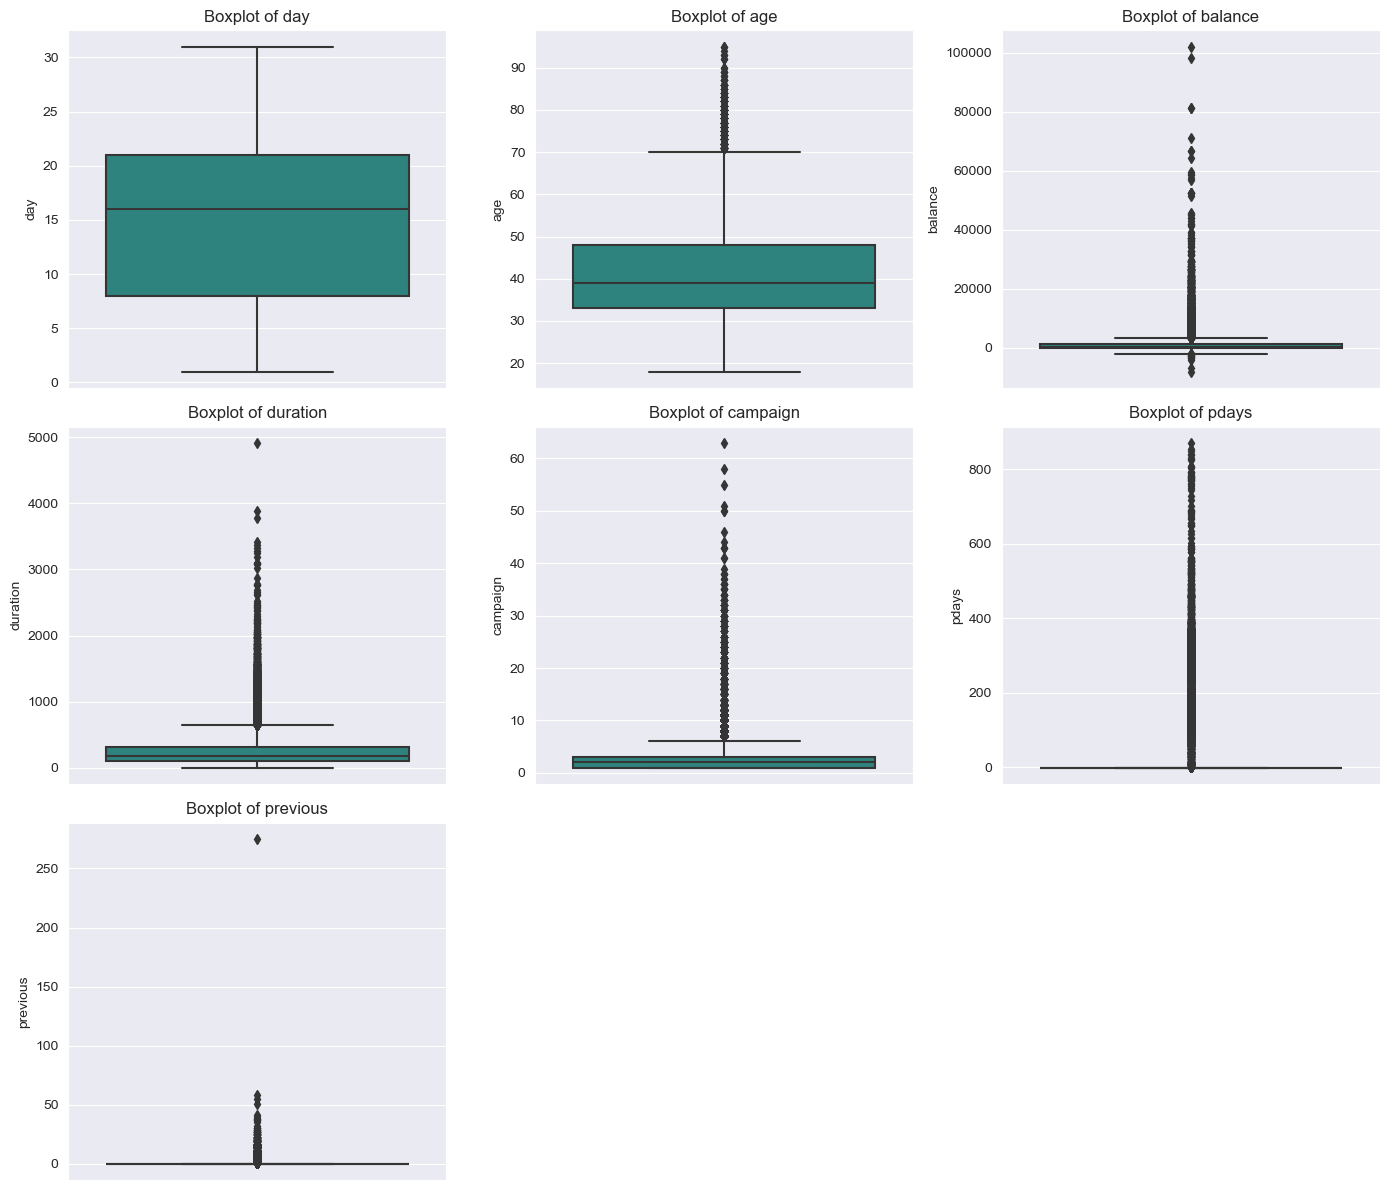

In [20]:
# Boxplot - Numerical Features

# Create subplots: Adjust rows and columns based on the number of features
n_features = len(numerical_features)
n_rows = (n_features + 2) // 3  # 3 columns per row
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(14, 4 * n_rows))  # Dynamic height
axes = axes.flatten()  # Flatten axes array to iterate easily

# Plot boxplots for each numerical column
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df, y=col, ax=axes[i], palette="viridis")  # Boxplot for each column
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(col)

# Turn off unused axes (if any)
for j in range(n_features, len(axes)):
    axes[j].axis('off')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


`day` does not have any outliers. All the other features have outliers. They should be further investigate.

### 5. Correlation Analysis

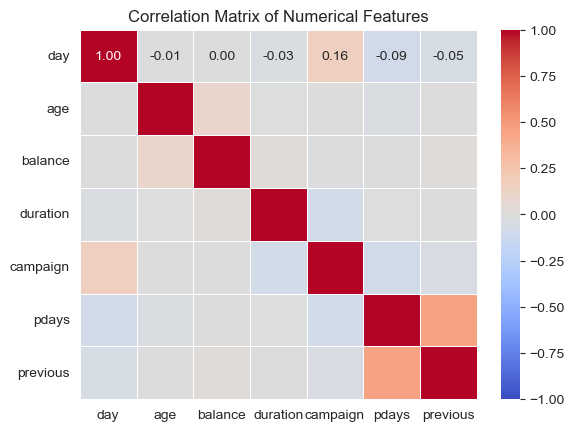

In [22]:
# Correlation Matrix - for continuous variables

correlation_matrix = df[numerical_features].corr()

# Plot the correlation matrix using a heatmap
plt.figure()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

After calculating the correlation matrix for the numerical features, most of the features were found to have weak or negligible correlations with each other, indicating minimal multicollinearity. However, one notable observation is:

- pdays and previous have a moderate positive correlation of approximately 0.5.

Interpretation:
- This suggests that there is some degree of overlap in the information provided by these two features.
- Clients who were contacted more frequently during previous campaigns may tend to have a higher number of days since the last contact, though this relationship is not extremely strong.

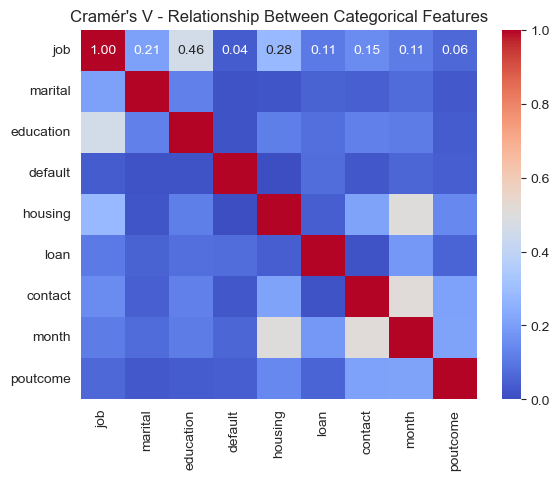

In [28]:
# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2_stat, p_value, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()  # Sum of all values in the contingency table
    return np.sqrt(chi2_stat / (n * (min(confusion_matrix.shape) - 1)))

# List of categorical features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Initialize an empty DataFrame with the same features as both rows and columns
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_features), len(categorical_features))),
                                index=categorical_features, columns=categorical_features)

# Fill in the matrix with Cramér's V values
for feature_1 in categorical_features:
    for feature_2 in categorical_features:
        if feature_1 != feature_2:
            # Create a contingency table
            contingency_table = pd.crosstab(df[feature_1], df[feature_2])
            cramers_v_matrix.loc[feature_1, feature_2] = cramers_v(contingency_table)
        else:
            cramers_v_matrix.loc[feature_1, feature_2] = 1.0  # Cramér's V is 1 for the same feature

# Plotting the heatmap of Cramér's V values
plt.figure()
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1, fmt=".2f", cbar=True)
plt.title("Cramér's V - Relationship Between Categorical Features")
plt.show()

The correlation matrix for categorical variables reveals that some variables, such as job and education (0.46), and month and housing (0.50), show moderate relationships. However, most categorical variables show weak correlations with each other, suggesting limited interdependence between factors like marital status, loan, and default.

### 6. Check for Duplicate Records

In [30]:
df.duplicated().sum()

0

### 7. Class Imbalance

Target Value Counts:
no     39922
yes     5289
Name: y, dtype: int64

Target Proportions (in %):
no     88.30152
yes    11.69848
Name: y, dtype: float64


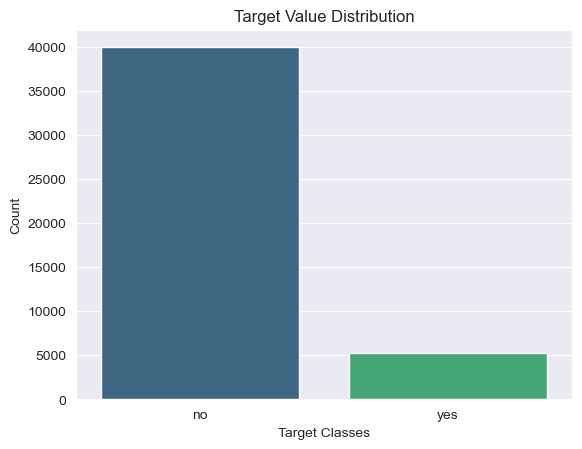

In [31]:
# Check the distribution of target values
target_counts = df['y'].value_counts()
target_proportions = df['y'].value_counts(normalize=True) * 100

# Display results
print("Target Value Counts:")
print(target_counts)
print("\nTarget Proportions (in %):")
print(target_proportions)

# Plotting the distribution
plt.figure()
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Value Distribution")
plt.xlabel("Target Classes")
plt.ylabel("Count")
plt.show()

Observations:
- The dataset is highly imbalanced, with the majority class (no) making up 88.30% of the data, while the minority class (yes) comprises only 11.70%.
- The imbalance indicates that the dataset may pose challenges for classification algorithms, as the model could become biased toward predicting the majority class.

### 8. Relationship between the Features and the Target Variable

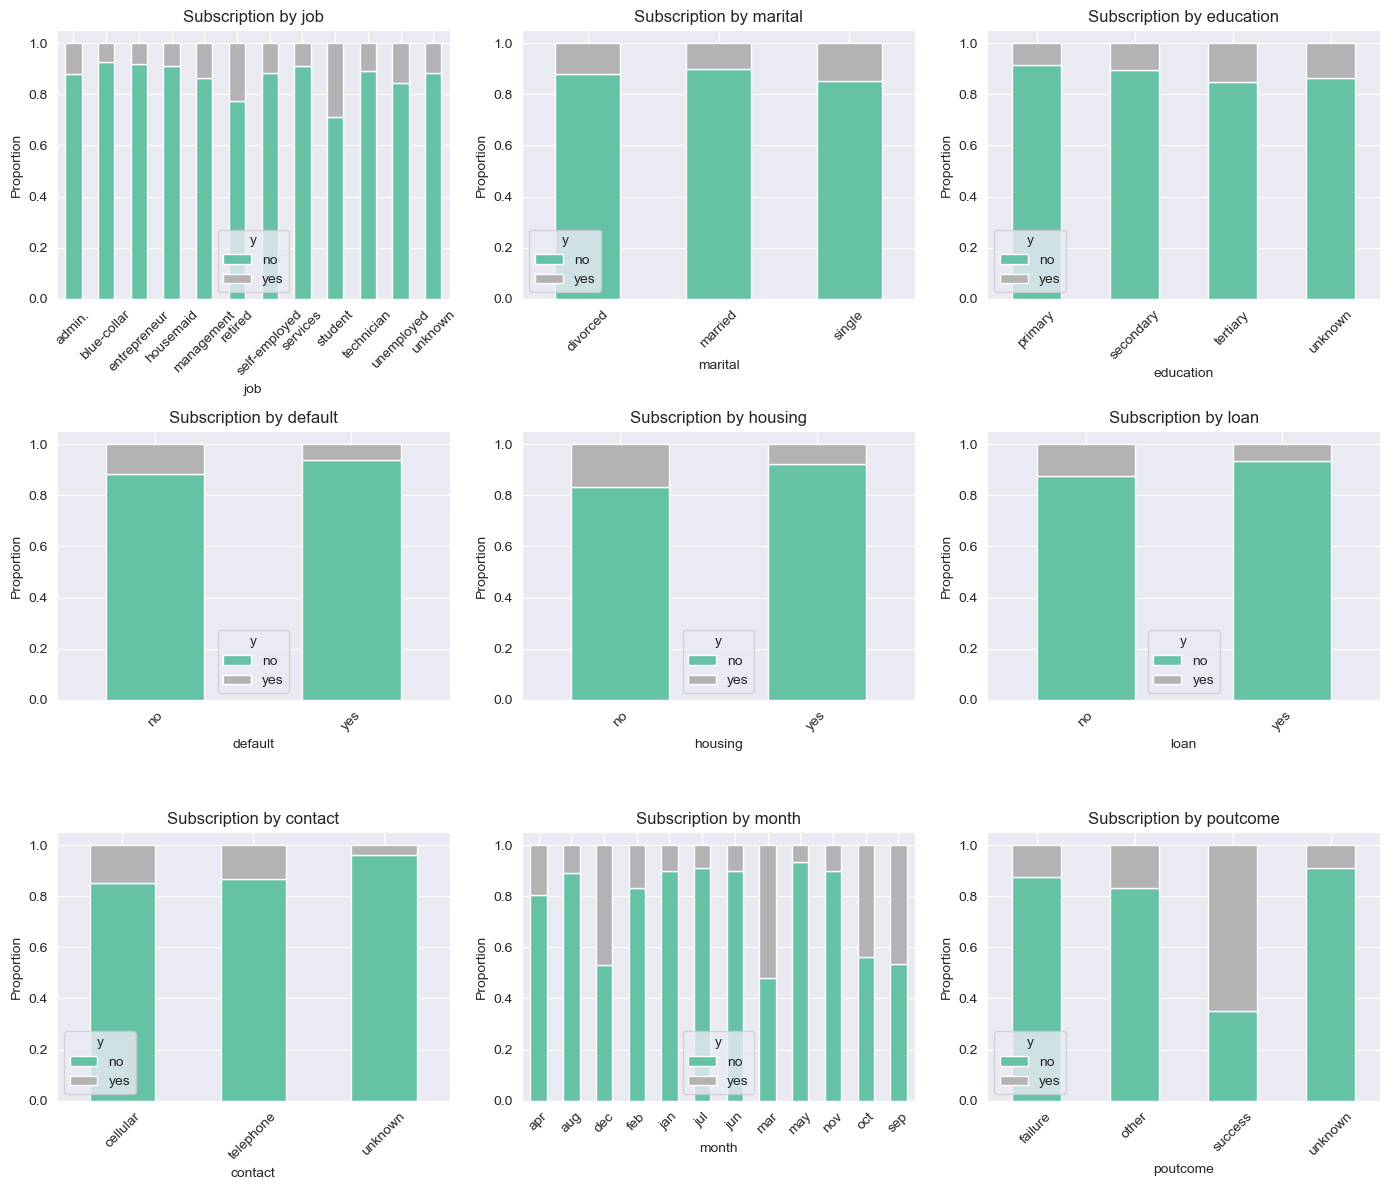

In [38]:
# Categorical Features

# Create subplots: 3 rows, 3 columns for 8 subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 12))  # Adjust grid size based on 8 subplots
axes = axes.flatten()  # Flatten the axes array to iterate easily

# Plot each column in a subplot
for i, col in enumerate(categorical_features):
    # Create a crosstab to get the count of target (y) for each category
    cross_tab = pd.crosstab(df[col], df['y'], normalize='index')
    
    # Plot stacked bar plot
    cross_tab.plot(kind='bar', stacked=True, ax=axes[i], colormap='Set2' )
    
    axes[i].set_title(f"Subscription by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Proportion')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.show()

General Insights:
- Subscription Trends: Job, education, housing, and loan status significantly impact whether a client subscribes to a term deposit. People with managerial roles or those in the blue-collar category seem to have higher subscription rates. Clients with tertiary education also have a higher subscription rate compared to others.
- Feature Relevance: Some features like contact and month show a clear relationship with subscription, while others like default and poutcome have more mixed or lower impact on subscription.
- Potential Issues: Features like unknown could cause issues if not handled properly, as they have a significant number of entries.


Target Skewness: For most features, there is a heavy skew towards the no class for subscription, meaning non-subscribing clients dominate the dataset.


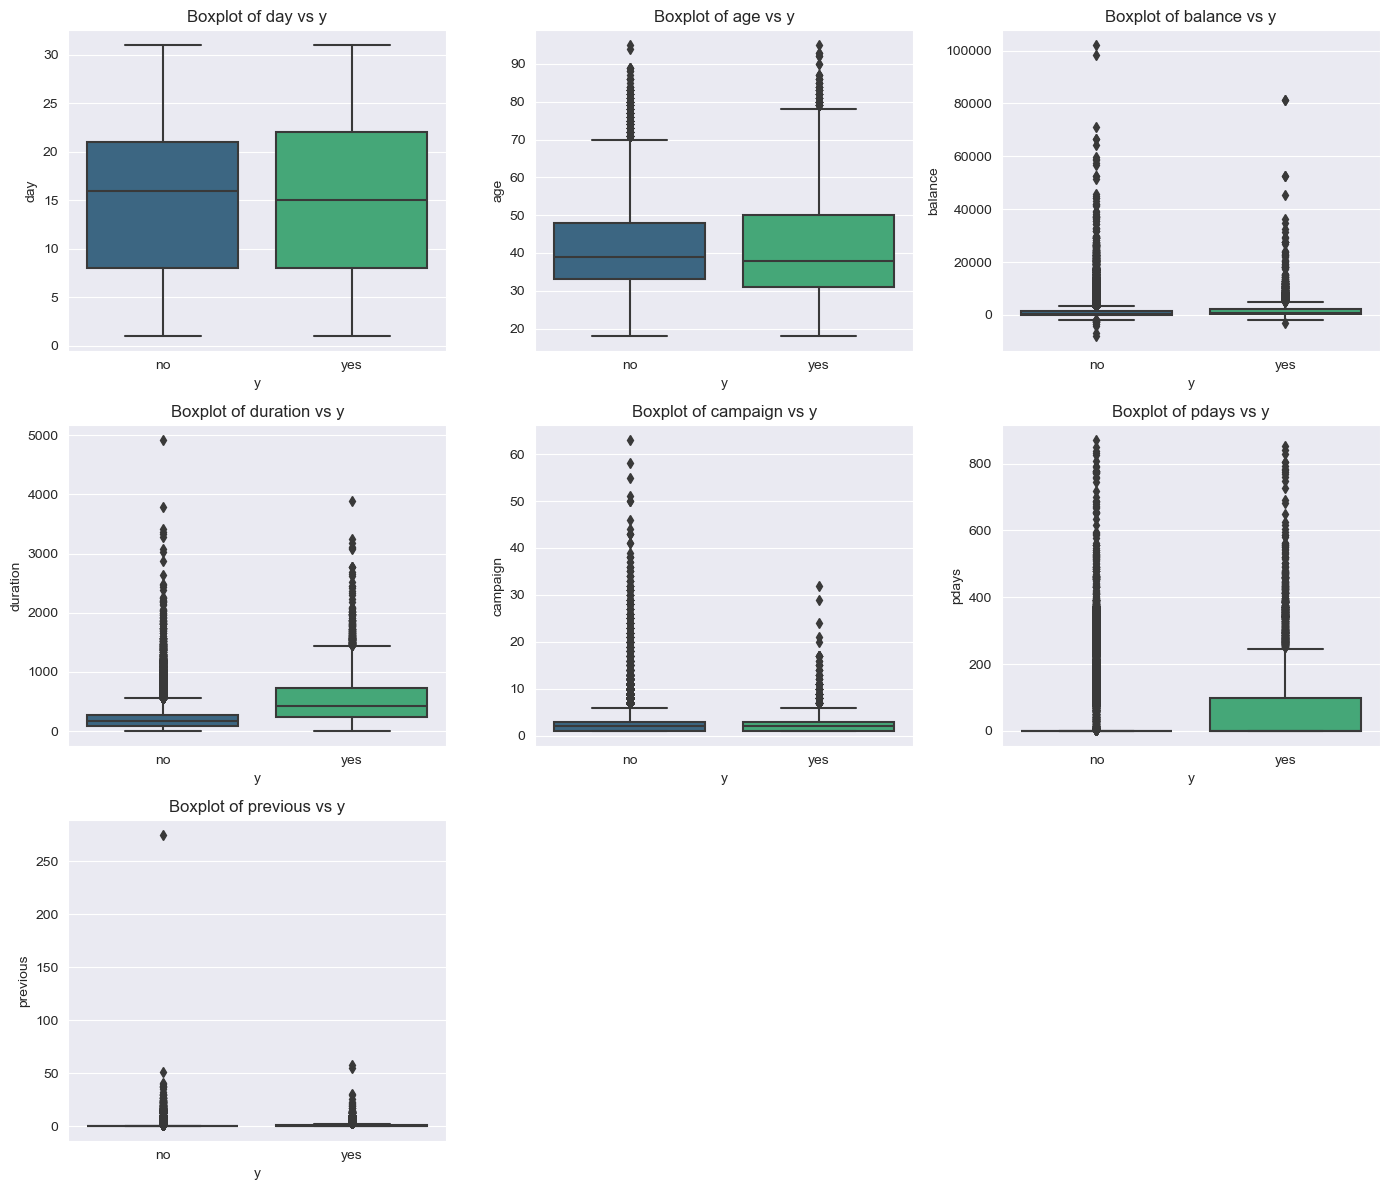

In [42]:
# Numerical Features

# Create subplots: 3 rows and 3 columns for 7 subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 12))  # Adjust grid size
axes = axes.flatten()  # Flatten the axes array to iterate easily

# Plot each continuous column in a subplot
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df, x='y', y=col, ax=axes[i], palette="viridis")  # Boxplot of feature vs label
    axes[i].set_title(f"Boxplot of {col} vs y")
    axes[i].set_xlabel('y')
    axes[i].set_ylabel(col)

# Turn off unused axes (if any)
for j in range(len(numerical_features), len(axes)):
    axes[j].axis('off')

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.show()

### 9. Correlation between Features and the Target Variable

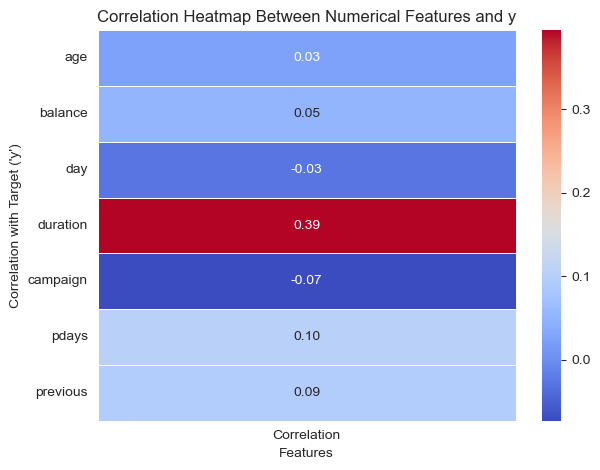

In [49]:
# Numerical features vs v

# Encode the target variable 'y' to numerical format for correlation calculation
df['y_encoded'] = df['y'].map({'yes': 1, 'no': 0})

# Select numerical features and calculate correlation with the target variable
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlations = df[numerical_columns].corr()['y_encoded'].drop('y_encoded')  # Correlation with the target

# Convert to DataFrame for better visualization in heatmap
correlation_df = correlations.reset_index()
correlation_df.columns = ['Feature', 'Correlation']

# Plot the heatmap vertically
plt.figure()  # Adjust width for horizontal alignment
sns.heatmap(
    correlation_df.set_index('Feature'),
    annot=True,
    cmap='coolwarm',
    cbar=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap Between Numerical Features and y")
plt.xlabel("Features")
plt.ylabel("Correlation with Target ('y')")
plt.tight_layout()
plt.show()

# Clean up the temporary encoded column
df.drop(columns=['y_encoded'], inplace=True)

- The correlation analysis of numerical features with the target variable (`y`) shows that most features have low correlation values, with most falling below 0.15. 
- Notably, **`duration`** has the highest correlation at 0.39, indicating a moderate positive relationship with the target. 
- In contrast, **`day`** and **`campaign`** exhibit weak negative correlations of **-0.03** and **-0.07**, respectively, suggesting little to no influence on the likelihood of subscription. 
- These results suggest that the features related to time and campaign have minimal impact on predicting customer subscriptions.

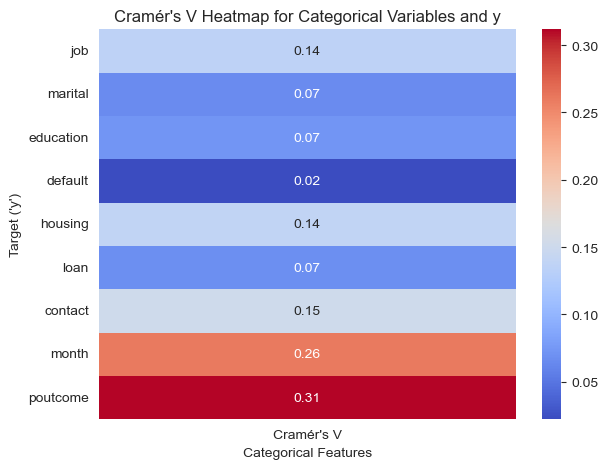

In [52]:
# Categorical Features

# Cramér's V calculation function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2_stat, p_val, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2_stat / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1)) if chi2_stat > 0 else 0

# Initialize a dictionary to store Cramér's V values for each feature
cramers_v_values = {}

# Iterate over each categorical column and calculate Cramér's V with 'y'
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']  # Replace with your categorical columns

for col in categorical_columns:
    crosstab = pd.crosstab(df[col], df['y'])
    if not crosstab.empty:
        cramers_v_values[col] = cramers_v(df[col], df['y'])
    else:
        cramers_v_values[col] = 0  # Assign 0 if there are no valid combinations

# Convert the dictionary to a DataFrame for easy plotting
cramers_v_df = pd.DataFrame(cramers_v_values, index=["Cramér's V"])
cramers_v_df = cramers_v_df.T  # Transpose to have features as rows

# Plotting the heatmap
plt.figure()
sns.heatmap(cramers_v_df, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("Cramér's V Heatmap for Categorical Variables and y")
plt.xlabel("Categorical Features")
plt.ylabel("Target ('y')")
plt.tight_layout()
plt.show()

The **Cramér's V values** indicate the strength of association between each feature and the target (`y`):  

Cramér's V ranges from 0 to 1, where:
- Close to 0: Weak association.
- Close to 1: Strong association.

1. **`poutcome` (0.311)** and **`month` (0.260)** show the strongest associations, making them important for predicting subscriptions.  
2. **`contact` (0.151)** and **`housing` (0.139)** have weak but notable associations.  
3. Features like **`default` (0.022)** and **`marital` (0.065)** show very weak associations and may have limited impact.  
